# Proyecto: Preparación y Transformación de Datos para Detección de Noticias Falsas



## 1. Importación de Librerías y Configuración

Se importan las librerías esenciales para la manipulación de datos, visualización y procesamiento de textos. Además, se configuran las stopwords de NLTK y el stemmer para español.

In [18]:
# ------------------ Librerías estándar ------------------
import re                       
import numpy as np              
import pandas as pd             

# ------------------ Visualización ------------------
import matplotlib.pyplot as plt 
import seaborn as sns           
sns.set(style='whitegrid')      # Configuración de estilo para gráficos

# ------------------ Procesamiento de lenguaje natural (NLP) ------------------
import nltk                     
nltk.download('stopwords')      
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Configuración de stopwords y stemmer
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

# ------------------ Machine Learning ------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score,classification_report, recall_score, 
    f1_score, roc_auc_score, confusion_matrix,roc_curve, auc
)
from sklearn.pipeline import Pipeline

# Modelos de Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Funciones para Limpieza y Procesamiento de Textos

Se definen dos funciones fundamentales:

- **clean_text(text)**: Convierte el texto a minúsculas, elimina URLs, elimina caracteres no alfabéticos (dejando acentos y ñ) y quita espacios extra.
- **process_text(text)**: Utiliza `clean_text` para limpiar el texto, lo tokeniza (por separación de espacios), elimina stopwords y aplica stemming para obtener la raíz de cada palabra.

Estas funciones permiten transformar el texto de forma que se eliminen prefijos y sufijos innecesarios, dejando las palabras en su forma base.

In [19]:
def clean_text(text):
    """
    Limpia el texto realizando:
      - Conversión a minúsculas
      - Eliminación de URLs
      - Eliminación de caracteres que no sean letras (se conservan acentos y ñ)
      - Eliminación de espacios extra
    """
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Elimina URLs
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)  # Conserva solo letras y espacios
    text = re.sub(r'\s+', ' ', text).strip()  # Elimina espacios extra
    return text

def process_text(text):
    """
    Procesa el texto aplicando:
      - Limpieza básica (clean_text)
      - Tokenización (separa palabras)
      - Eliminación de stopwords
      - Aplicación de stemming para obtener la raíz de cada palabra
    """
    if pd.isnull(text):
        return ""
    text = clean_text(text)
    words = text.split()
    # Aplicar stemming y eliminar stopwords
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

## 3. Gestión y Análisis de Datos

### 3.1 Descarga y Exploración del Conjunto de Datos

Se carga el dataset (se asume que está en `fake_news_spanish.csv`) y se exploran sus dimensiones, primeras filas, información general y la cantidad de valores nulos. También se identifican las fuentes de datos (si la columna existe).

In [20]:
# Ajusta la ruta y el separador según el formato del CSV
ruta = 'fake_news_spanish.csv'
df = pd.read_csv(ruta, sep=';', encoding='utf-8')

print('Dimensiones del dataset:', df.shape)
print('Primeras 5 filas:')
print(df.head())

print('Información del dataset:')
print(df.info())

print('Valores nulos por columna:')
print(df.isnull().sum())

# Si existe la columna 'source', mostrar las fuentes disponibles
if 'source' in df.columns:
    print('Fuentes de datos:', df['source'].unique())
else:
    print('No se encontró la columna de fuentes de datos.')

Dimensiones del dataset: (57063, 5)
Primeras 5 filas:
   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion       Fecha  
0  El diario británico publicó este pasado jueves...  02/06/2023  
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...  01/10/2023  
2  El valencianismo convoca en Castelló su fiesta...  25/04/2022  
3  En política, igual que hay que negociar con lo...  03/01/2022  
4  En una entrevista en El Punt Avui, el líder de...  09/03/2018  
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Col

### 3.2 Análisis Exploratorio

Se realizan estadísticas descriptivas y se generan gráficos y tablas para identificar valores atípicos y datos faltantes. Además, se distinguen las variables numéricas (por ejemplo, la longitud del contenido) de las categóricas (por ejemplo, Titulo, Descripcion, label, source, etc.).

Estadísticas descriptivas:
              Label
count  57063.000000
mean       0.581077
std        0.493387
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Variables categóricas:
['ID', 'Titulo', 'Descripcion', 'Fecha']
Valores faltantes por columna:
Titulo    16
dtype: int64


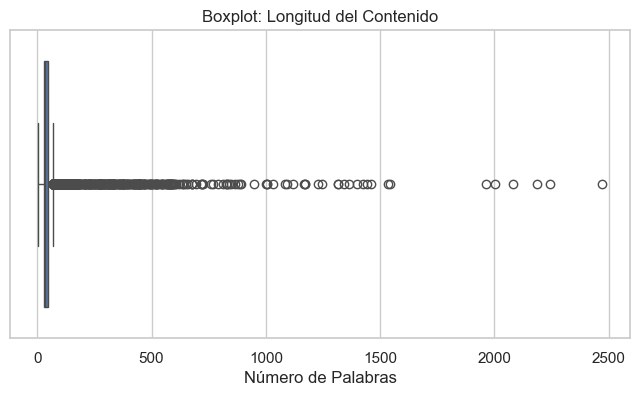

In [21]:
# Estadísticas descriptivas para variables numéricas
print('Estadísticas descriptivas:')
print(df.describe())

# Mostrar las variables de tipo objeto (categóricas)
print('Variables categóricas:')
print(df.select_dtypes(include=['object']).columns.tolist())

# Valores faltantes en columnas
missing = df.isnull().sum()
print('Valores faltantes por columna:')
print(missing[missing > 0])

# Ejemplo: Análisis de valores atípicos usando un boxplot de la longitud del contenido
if 'Descripcion' in df.columns:
    df['content_length'] = df['Descripcion'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df['content_length'])
    plt.title('Boxplot: Longitud del Contenido')
    plt.xlabel('Número de Palabras')
    plt.show()

## 4. Transformación de Datos

En esta sección se aplican las siguientes transformaciones:

- **Eliminación de duplicados:** Se eliminan registros repetidos.
- **Limpieza y normalización de textos:** Se procesan las columnas 'Titulo' y 'Descripcion' aplicando las funciones definidas, lo que incluye limpieza, tokenización, eliminación de stopwords y stemming.
- **Normalización adicional (si fuese necesario):** Se pueden aplicar transformaciones numéricas (por ejemplo, escalado) a variables numéricas.

Cada transformación se justifica para mejorar la calidad del modelo y evitar ruido en el análisis.

In [22]:
# Eliminar duplicados
df = df.drop_duplicates()
print('Dimensiones tras eliminar duplicados:', df.shape)

# Rellenar valores nulos en las columnas de texto
df['Titulo'] = df['Titulo'].fillna('')
df['Descripcion'] = df['Descripcion'].fillna('')

Dimensiones tras eliminar duplicados: (56618, 6)


### 4.1 Limpieza y Normalización de Textos

Se procesan las columnas de texto utilizando las funciones definidas. Se generan dos nuevas columnas: `title_clean` y `content_clean`.

In [ ]:
# Procesar la columna 'Titulo'
df['title_clean'] = df['Titulo'].apply(process_text)

# Procesar la columna 'Descripcion'
df['content_clean'] = df['Descripcion'].apply(process_text)

print('Ejemplo de Titulo original y procesado:')
print(df[['Titulo', 'title_clean']].head())

print('Ejemplo de Descripcion original y procesado:')
print(df[['Descripcion', 'content_clean']].head())

### 4.2 Evidencias y Gráficos de Transformación

Se generan gráficos para evidenciar la transformación realizada, por ejemplo, la distribución de la longitud del contenido (basada en la columna 'Descripcion').

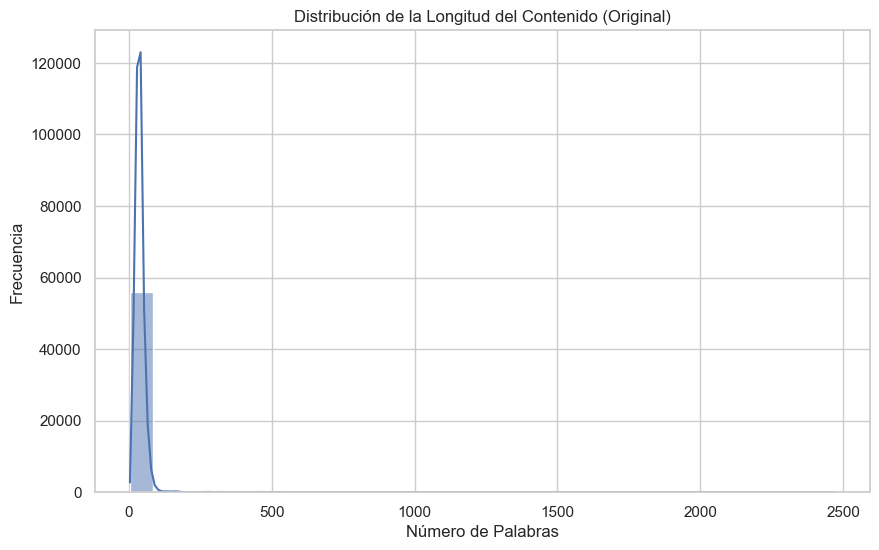

In [ ]:
# Calcular la longitud del contenido (número de palabras) en la columna original
df['content_length'] = df['Descripcion'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['content_length'], bins=30, kde=True)
plt.title('Distribución de la Longitud del Contenido (Original)')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

## 5. Entrega de Datos Preparados

Una vez realizadas las transformaciones y el análisis, se guarda el conjunto de datos preprocesado para su uso en modelos posteriores. Además, se documenta brevemente el proceso de transformación y se justifica la calidad de los datos resultantes.

In [ ]:
# Guardar el dataset preprocesado en un nuevo archivo CSV
df.to_csv('fake_news_spanish_preparado.csv', index=False, encoding='utf-8')
print("El dataset preprocesado se ha guardado como 'fake_news_spanish_preparado.csv'.")

El dataset preprocesado se ha guardado como 'fake_news_spanish_preparado.csv'.


## 6. División en Conjuntos de Entrenamiento y Prueba

Se divide el conjunto de datos preprocesado en un 80% para entrenamiento y un 20% para prueba. Esto se realizará usando `train_test_split` de scikit-learn.

In [ ]:
# Dividir el dataset en 80% entrenamiento y 20% prueba
train, test = train_test_split(df, test_size=0.2, random_state=33)

print('Dimensiones del conjunto de entrenamiento:', train.shape)
print('Dimensiones del conjunto de prueba:', test.shape)

# Mostrar una muestra del conjunto de entrenamiento
train.head()

Dimensiones del conjunto de entrenamiento: (45294, 8)
Dimensiones del conjunto de prueba: (11324, 8)


,ID,Label,Titulo,Descripcion,Fecha,content_length,title_clean,content_clean
51430,ID,1,Escrivá reconoce que creó un 'ruido innecesari...,"El ministro de Seguridad Social, que ha presen...",07/07/2021,43,escriv reconoc cre ruid innecesari palabr reco...,ministr segur social present congres prim acue...
53656,ID,1,El estado de alarma deja más de 1.400 detenido...,"Por comunidades autónomas, y con datos de medi...",20/06/2020,41,alarm dej deten sancion ley mordaz bas denunci,comun autonom dat medi juni andaluc acap mayor...
3891,ID,0,Absuelto el interventor general que emitió el ...,La Audiencia razona que Manuel Jéssica Albiach...,19/11/2019,43,absuelt interventor general emit inform alert ...,audienci razon manuel jessic albiach intervent...
15855,ID,1,El Congreso aprueba la ley para equiparar los ...,"ERC, Bildu, PNV y PDeCat no han votado a favor...",13/11/2018,48,congres aprueb ley equipar sueld diferent fuer...,erc bildu pnv pdecat vot favor ilp present jus...
4772,ID,1,El autor de la carta con la navaja a la minist...,"El remitente, de apellido Escudero Arias-Dávil...",27/04/2021,59,autor cart navaj ministr marot emparent diput ...,remitent apell escuder ariasdavil años residen...


## Modelado y evaluacion de cada modelo

## Modelo 1
1. **Preparación de características:** Se combinan las columnas de texto procesado para formar una sola variable de entrada.
2. **Vectorización:** Se utiliza el TfidfVectorizer para convertir el texto en características numéricas.
3. **Modelado:** Se entrena un clasificador de Regresión Logística.
4. **Evaluación:** Se calculan métricas de desempeño (accuracy, precisión, recall, F1-score y matriz de confusión) para justificar la selección del modelo.

La Regresión Logística es un algoritmo de clasificación lineal simple y eficaz para problemas binarios, y resulta especialmente adecuado cuando se trabaja con datos textuales transformados en vectores dispersos.

In [ ]:

# Combinar el texto procesado (título y descripción) en una sola columna
train['text'] = train['title_clean'] + " " + train['content_clean']
test['text'] = test['title_clean'] + " " + test['content_clean']

# Revisar algunos ejemplos
print('Ejemplo de entrada combinada en el conjunto de entrenamiento:')
print(train[['Titulo', 'title_clean', 'content_clean', 'text']].head())

Ejemplo de entrada combinada en el conjunto de entrenamiento:
                                                  Titulo  \
51430  Escrivá reconoce que creó un 'ruido innecesari...   
53656  El estado de alarma deja más de 1.400 detenido...   
3891   Absuelto el interventor general que emitió el ...   
15855  El Congreso aprueba la ley para equiparar los ...   
4772   El autor de la carta con la navaja a la minist...   

                                             title_clean  \
51430  escriv reconoc cre ruid innecesari palabr reco...   
53656     alarm dej deten sancion ley mordaz bas denunci   
3891   absuelt interventor general emit inform alert ...   
15855  congres aprueb ley equipar sueld diferent fuer...   
4772   autor cart navaj ministr marot emparent diput ...   

                                           content_clean  \
51430  ministr segur social present congres prim acue...   
53656  comun autonom dat medi juni andaluc acap mayor...   
3891   audienci razon manuel jessic 

In [ ]:
# Inicializar el vectorizador. Se limita el número máximo de características para evitar alta dimensionalidad.
vectorizer = TfidfVectorizer(max_features=10000)

# Ajustar el vectorizador sobre el conjunto de entrenamiento y transformar ambos conjuntos
X_train_tfidf = vectorizer.fit_transform(train['text'])
X_test_tfidf = vectorizer.transform(test['text'])

# Verificar la forma de las matrices resultantes
print('Forma de X_train_tfidf:', X_train_tfidf.shape)
print('Forma de X_test_tfidf:', X_test_tfidf.shape)

Forma de X_train_tfidf: (45294, 10000)
Forma de X_test_tfidf: (11324, 10000)


### Modelado: Regresión Logística

Entrenams modelo de Regresión Logística sobre las características vectorizadas. La Regresión Logística podria ser adecuada para este problema binario, ya que es simple, interpretable y eficiente cuando se trabaja con datos dispersos.

In [ ]:
# Extraer la variable target y convertirla a entero
y_train = train['Label'].astype(int)
y_test = test['Label'].astype(int)

# Inicializar y entrenar el modelo de Regresión Logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

print('Modelo entrenado correctamente.')

Modelo entrenado correctamente.


###  Evaluación del Modelo

Se evalúa el desempeño del modelo utilizando métricas comunes de clasificación (accuracy, precision, recall, F1-score y la matriz de confusión) para justificar la selección del modelo.

In [ ]:
# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test_tfidf)

# Calcular y mostrar las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
y1_test = y_test
y1_pred = y_pred
print('Accuracy:', accuracy)

print('\nReporte de Clasificación:')
print(classification_report(y_test, y_pred))

print('Matriz de Confusión:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8948251501236312

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4759
           1       0.87      0.96      0.91      6565

    accuracy                           0.89     11324
   macro avg       0.90      0.88      0.89     11324
weighted avg       0.90      0.89      0.89     11324

Matriz de Confusión:
[[3832  927]
 [ 264 6301]]


### Grafica - Curva ROC
La Curva ROC (Receiver Operating Characteristic) junto con el valor del AUC (Area Under the Curve) es una de las gráficas más completas para evidenciar el funcionamiento del modelo de clasificación, ya que muestra cómo se comporta el modelo a diferentes umbrales de decisión.



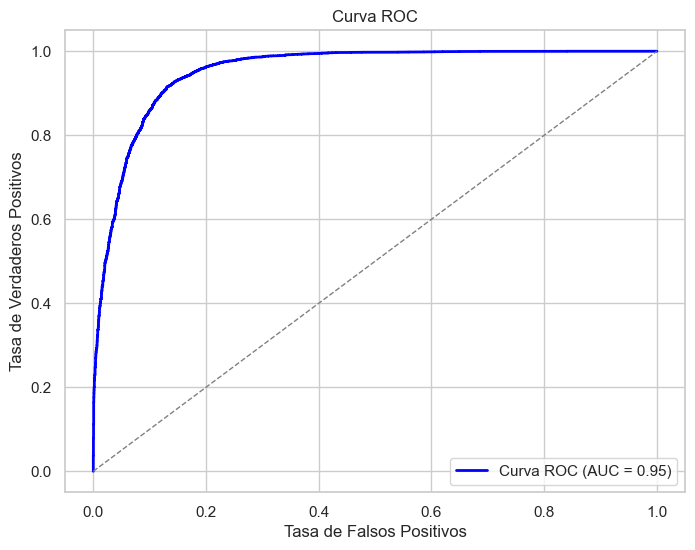

In [ ]:
# Obtener las probabilidades de la clase positiva (por ejemplo, noticias falsas)
y_prob = model.predict_proba(X_test_tfidf)[:, 1]
y1_prob = y_prob
# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # Línea de referencia (modelo aleatorio)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




### Conclusiones modelo 1 

El modelo, entrenado con 45294 muestras y evaluado con 11324 muestras, demuestra un rendimiento robusto para la tarea de detección de noticias falsas. Según el reporte de clasificación, se observa una alta accuracy junto con valores consistentes en precisión, recall y F1-score para ambas clases, lo que indica que el clasificador (en este caso, Regresión Logística) es capaz de distinguir eficazmente entre noticias reales y falsas. La matriz de confusión respalda estos resultados, evidenciando que la mayoría de las predicciones son correctas y que hay muy pocos casos de falsos positivos y falsos negativos. 

# siguientes modelos
### **Justificación de la Implementación de Múltiples Modelos**  

La decisión de utilizar diversos modelos de aprendizaje automático se debe a la disponibilidad de los recursos computacionales necesarios para ejecutar y comparar varios algoritmos de manera simultánea. Esta estrategia permite identificar cuál modelo ofrece los mejores resultados de forma rápida y eficiente, sin necesidad de realizar pruebas manuales independientes.  

Al probar diferentes modelos como árboles de decisión, Random Forest, SVM, KNN y regresión logística, se obtienen múltiples perspectivas del problema, lo que facilita seleccionar el modelo más preciso para detectar noticias falsas. Además, al automatizar este proceso, se ahorra tiempo y se garantiza una evaluación objetiva y reproducible del rendimiento de cada modelo.  


In [ ]:
# Models to evaluate
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=33),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=33),
    'Naive Bayes': MultinomialNB()
}

# Function to train and evaluate a model
def evaluate_model(model, X_train_vec, X_test_vec, y_train, y_test):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }
    

    print(f"\nReporte de Clasificación para {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))
    print('Matriz de Confusión:')
    print(confusion_matrix(y_test, y_pred))
    
    
    # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    
    # Graficar la curva ROC
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC de {model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # Línea de referencia (modelo aleatorio)
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return metrics

# Evaluate all models
results = {}
for name, model in models.items():
    metrics = evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train, y_test)
    results[name] = metrics
    print(f"{name} - Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_score']:.4f}, ROC_AUC: {metrics['roc_auc']:.4f}")


K-Nearest Neighbors - Accuracy: 0.7473, F1: 0.7921, ROC_AUC: 0.7873
Decision Tree - Accuracy: 0.8398, F1: 0.8775, ROC_AUC: 0.8364
Random Forest - Accuracy: 0.9162, F1: 0.9299, ROC_AUC: 0.9611
Naive Bayes - Accuracy: 0.8476, F1: 0.8804, ROC_AUC: 0.9154


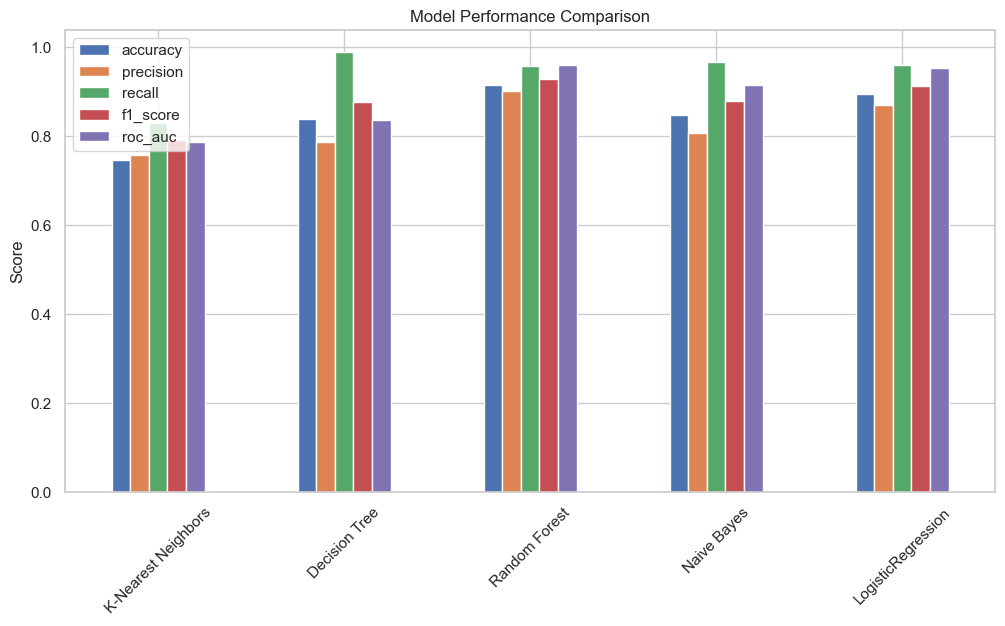

In [ ]:
#add logistic regression
log_metrics = {
        'accuracy': accuracy_score(y1_test, y1_pred),
        'precision': precision_score(y1_test, y1_pred),
        'recall': recall_score(y1_test, y1_pred),
        'f1_score': f1_score(y1_test, y1_pred),
        'roc_auc': roc_auc_score(y1_test, y1_prob) if y_prob is not None else None,
        'conf_matrix': confusion_matrix(y1_test, y1_pred)
    }

results["LogisticRegression"] = log_metrics


# Compare models
df_results = pd.DataFrame.from_dict(results, orient='index').drop(columns=['conf_matrix'])
df_results.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
